<a href="https://colab.research.google.com/github/LeeYuuuan/EIT-forward-and-inverse/blob/main/Biyesheji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
from torch.utils.data import TensorDataset,DataLoader,Dataset
from torch.autograd import Variable # 获取变量
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


In [8]:
import sys
sys.path.append(r"/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning")
import torch_rbf as rbf

In [9]:
class DealDataset(Dataset):

    def __init__(self, a):
        
        # load the .csv simulation data
        dic_path = "/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/data/"
        X = np.loadtxt(dic_path + 'datacsv1.csv', delimiter=';', dtype=np.float32)
        y = np.loadtxt(dic_path + 'datacsv.csv', delimiter=';', dtype=np.float32)

        # split train/test dataset
        X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

        X_train = np.zeros([X_train1.shape[0], 1, 16, 12]) # shape: count * 1 * 16(angle) * 12(voltage)
        X_test = np.zeros([X_test1.shape[0], 1, 16, 12])

        # return different data
        if a == 'train':
            self.x = X_train
            self.y = y_train
            self.len = X_train.shape[0]
        elif a == 'test':
            self.x = X_test
            self.y = y_test
            self.len = X_test.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [ ]:
# 定义网络结构
class CNNnet(torch.nn.Module):
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(CNNnet,self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.conv1_1 = nn.Sequential(
            # (1, 16, 12)pytorch输入不用定义大小，因为参数过多写成nn.Conv2d(1,64,3,1，1)形式容易出错，有的参数默认了
            nn.Conv2d(
                in_channels=1, # 单通道
                out_channels=64, # 64通道
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1 # 零填充
            ),
            torch.nn.BatchNorm2d(64), # 批量归一化
            nn.ELU(), # ELU激活函数
        )
        self.conv1_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2) # 最大池化层，核大小为2
        )
        self.conv2_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.conv2_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2,ceil_mode=True) # 平均池化层，核大小为2，2×1经过这层变成1×0，报错，但有ceil_mode=True为向上取整，变成1×1
        )
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i + 1]))
        self.mlp2 = torch.nn.Linear(512,576) # 输出层，512是输入这层的大小，576是输出的大小

    def forward(self, x):
        """forward  propagation"""
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = x.view(x.size(0),-1) # 四维数据（数据量，通道，纵向，横向），展开为二维（数据量，只有横向）
        for i in range(len(self.rbf_layers)):
            x = self.rbf_layers[i](x)
            x = self.linear_layers[i](x)
        x = self.mlp2(x)
        return x

In [10]:
# Get Dataset
dealDataset1 = DealDataset(a = 'train')

#将这个类传给DataLoader
train_loader = DataLoader(dataset=dealDataset1,
                          batch_size=32,
                          shuffle=True)

In [ ]:
layer_widths = [512] #神经元数量
layer_centres = [40]
basis_func = rbf.gaussian #初始偏置

model = CNNnet(layer_widths, layer_centres, basis_func) #初始化模型
print(model)  #显示模型参数
model = model.float() #模型参数转为float型
device = torch.device('cuda:0')
model.to(device) #训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型

loss_func = torch.nn.MSELoss() #定义损失函数
opt = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9) #动量梯度下降法

dealDataset2 = DealDataset(a='test')  #测试集数据

test_loader = DataLoader(dataset=dealDataset2,
                          batch_size=32,
                          shuffle=True)


In [12]:
'''
下面矩阵存放训练过程中损失函数等数据
'''
loss_count = []
iter_loss = []
batch_loss = []
test_loss = []
epochs=100 

train MSE 0:	 0.03841310739517212
train MSE 20:	 0.004044792614877224
train MSE 40:	 0.0019904563669115305
test MSE 1:	 0.0020046543795615435
train MSE 0:	 0.0019654103089123964
train MSE 20:	 0.0019267505267634988
train MSE 40:	 0.0019031645497307181
test MSE 2:	 0.0019473271677270532
train MSE 0:	 0.0019074674928560853
train MSE 20:	 0.0018639753106981516
train MSE 40:	 0.0019892831332981586
test MSE 3:	 0.001889503444544971
train MSE 0:	 0.0019533217418938875
train MSE 20:	 0.0018974026897922158
train MSE 40:	 0.0019755433313548565
test MSE 4:	 0.002024107612669468
train MSE 0:	 0.0019201521063223481
train MSE 20:	 0.0018886636244133115
train MSE 40:	 0.0019347568741068244
test MSE 5:	 0.002000292530283332
train MSE 0:	 0.001914651831611991
train MSE 20:	 0.0019428572850301862
train MSE 40:	 0.0018941470189020038
test MSE 6:	 0.0019312658114358783
train MSE 0:	 0.0019455676665529609
train MSE 20:	 0.0018894049571827054
train MSE 40:	 0.001959926215931773
test MSE 7:	 0.0019880048930

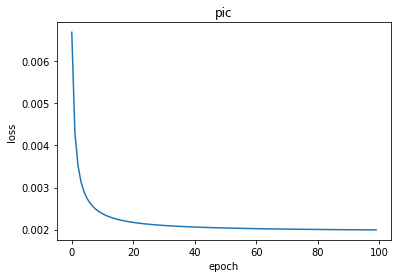

In [13]:
for epoch in range(epochs):
    for i, (x, y)in enumerate(train_loader):
        batch_x = Variable(x).to(torch.float32) # torch.Size([, 1, 16, 12])
        batch_x = batch_x.cuda()
        batch_y = Variable(y).to(torch.float32) # torch.Size([576])
        batch_y = batch_y.cuda()
        out = model(batch_x)        # 获取最后输出
        loss = loss_func(out, batch_y)        # 获取损失
        batch_loss.append(loss.cuda().data.cpu().numpy())    # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
        '''
        每20个数据显示一次训练集均方误差
        '''
        if i%20 == 0:
            loss_count.append(loss)
            print('train MSE {}:\t'.format(i), loss.item())
            torch.save(model,r'C:\Users\luoxinyu\Desktop\log_CNN')

    for a,b in test_loader:
        test_x = Variable(a).to(torch.float32)
        test_x = test_x.cuda()
        test_y = Variable(b).to(torch.float32)
        test_y = test_y.cuda()
        out = model(test_x)
        loss = loss_func(out, test_y)
        test_loss.append(loss.cuda().data.cpu().numpy())
        '''
        每轮示一次训练集均方误差
        '''
        print('test MSE {}:\t'.format(epoch+1), loss.item())
        break
    iter_loss.append(np.average(np.array(batch_loss)))

'''
绘制测试集 轮数与均方误差图像
'''
x = np.arange(epochs)
y = np.array(iter_loss)
plt.plot(x, y)
plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
dic_path = "/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/data/"
X = np.loadtxt(dic_path + 'datacsv1.csv', delimiter=';', dtype=np.float32)
y = np.loadtxt(dic_path + 'datacsv.csv', delimiter=';', dtype=np.float32)
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = np.zeros([X_train1.shape[0], 1, 16, 12]) # shape: count * 1 * 16(angle) * 12(voltage)
X_test = np.zeros([X_test1.shape[0], 1, 16, 12])


In [ ]:
for i in range(X_train1.shape[0]):
    X_train[i, 0, :, :] = X_train1[i].reshape(16, 12)
for i in range(X_test1.shape[0]):
    X_test[i, 0, :, :] = X_test1[i].reshape(16, 12)

In [ ]:
X_train[0][0][0].shape

(12,)

In [ ]:
class DealDataset(Dataset):
    """
        下载数据、初始化数据，都可以在这里完成
        当我们集成了一个 Dataset类之后，我们需要写 len 方法，该方法提供了dataset的大小； getitem 方法， 该方法支持从 0 到 len(self)的索引
    """
    def __init__(self,a):
        dic_path = "/content/drive/MyDrive/Colab Notebooks/EIT/EITDeepLearning/data"
        X = np.loadtxt(dic_path + 'datacsv1.csv', delimiter=',', dtype=np.float32)
        y = np.loadtxt('G:\\r=0.15\\junyun\\y.csv', delimiter=',', dtype=np.float32)
        X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        X_train = np.zeros([X_train1.shape[0], 1, 16, 12])
        X_test = np.zeros([X_test1.shape[0], 1, 16, 12])
        for i in range(X_train1.shape[0]):
            X_train[i, 0, :, :] = X_train1[i].reshape(16, 12)
        for i in range(X_test1.shape[0]):
            X_test[i, 0, :, :] = X_test1[i].reshape(16, 12)
        if a=='train':
            self.x = X_train
            self.y = y_train
            self.len = X_train.shape[0]
        elif a=='test':
            self.x = X_test
            self.y = y_test
            self.len = X_test.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

# 实例化这个类，然后我们就得到了Dataset类型的数据.
dealDataset1 = DealDataset(a='train')

#将这个类传给DataLoader
train_loader = DataLoader(dataset=dealDataset1,
                          batch_size=32,
                          shuffle=True)

# 定义网络结构
class CNNnet(torch.nn.Module):
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(CNNnet,self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.conv1_1 = nn.Sequential(
            # (1, 16, 12)pytorch输入不用定义大小，因为参数过多写成nn.Conv2d(1,64,3,1，1)形式容易出错，有的参数默认了
            nn.Conv2d(
                in_channels=1,#单通道
                out_channels=64,#64通道
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1#零填充
            ),
            torch.nn.BatchNorm2d(64),#批量归一化
            nn.ELU(),#ELU激活函数
        )
        self.conv1_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)#最大池化层，核大小为2
        )
        self.conv2_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.conv2_2 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
        )
        self.conv3_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4_1 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_2 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_3 = nn.Sequential(
            # (1, 28, 28)
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
        )
        self.conv4_4 = nn.Sequential(
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=3,  # 卷积filter, 移动块长
                stride=1,  # filter的每次移动步长
                padding=1
            ),
            torch.nn.BatchNorm2d(512),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2,ceil_mode=True)#平均池化层，核大小为2，2×1经过这层变成1×0，报错，但有ceil_mode=True为向上取整，变成1×1
        )
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i + 1]))
        self.mlp2 = torch.nn.Linear(512,576) #输出层，512是输入这层的大小，576是输出的大小
    '''
    前向传播
    '''
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = x.view(x.size(0),-1)#四维数据（数据量，通道，纵向，横向），展开为二维（数据量，只有横向）
        for i in range(len(self.rbf_layers)):
            x = self.rbf_layers[i](x)
            x = self.linear_layers[i](x)
        x = self.mlp2(x)
        return x
layer_widths = [512] #神经元数量
layer_centres = [40]
basis_func = rbf.gaussian #初始偏置

model = CNNnet(layer_widths, layer_centres, basis_func) #初始化模型
print(model)  #显示模型参数
model = model.float() #模型参数转为float型
device = torch.device('cuda:0')
model.to(device) #训练数据和模型数据类型要统一，并且pytorch-gpu数据类型要变成指定类型

loss_func = torch.nn.MSELoss() #定义损失函数
opt = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9) #动量梯度下降法

dealDataset2 = DealDataset(a='test')  #测试集数据

test_loader = DataLoader(dataset=dealDataset2,
                          batch_size=32,
                          shuffle=True)

'''
下面矩阵存放训练过程中损失函数等数据
'''
loss_count = []
iter_loss = []
batch_loss = []
test_loss = []
epochs=100 #轮数
for epoch in range(epochs):
    for i, (x, y)in enumerate(train_loader):
        batch_x = Variable(x).to(torch.float32) # torch.Size([, 1, 16, 12])
        batch_x = batch_x.cuda()
        batch_y = Variable(y).to(torch.float32) # torch.Size([576])
        batch_y = batch_y.cuda()
        out = model(batch_x)        # 获取最后输出
        loss = loss_func(out, batch_y)        # 获取损失
        batch_loss.append(loss.cuda().data.cpu().numpy())    # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
        '''
        每20个数据显示一次训练集均方误差
        '''
        if i%20 == 0:
            loss_count.append(loss)
            print('train MSE {}:\t'.format(i), loss.item())
            torch.save(model,r'C:\Users\luoxinyu\Desktop\log_CNN')

    for a,b in test_loader:
        test_x = Variable(a).to(torch.float32)
        test_x = test_x.cuda()
        test_y = Variable(b).to(torch.float32)
        test_y = test_y.cuda()
        out = model(test_x)
        loss = loss_func(out, test_y)
        test_loss.append(loss.cuda().data.cpu().numpy())
        '''
        每轮示一次训练集均方误差
        '''
        print('test MSE {}:\t'.format(epoch+1), loss.item())
        break
    iter_loss.append(np.average(np.array(batch_loss)))

'''
绘制测试集 轮数与均方误差图像
'''
x = np.arange(epochs)
y = np.array(iter_loss)
plt.plot(x, y)
plt.title('pic')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



